<a href="https://colab.research.google.com/github/zugzwang03/nas_unet/blob/main/NAS_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tensorflow opencv-python

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt
import numpy as np

def load_from_folder(folder, img_size=(64, 64), grayscale=True):
  images=[]
  for filename in sorted(os.listdir(folder))[:10]:
    path = os.path.join(folder, filename)
    img = load_img(path, target_size=img_size, color_mode='grayscale' if grayscale else 'rgb')
    img_array = img_to_array(img)
    images.append(img_array)
  return np.array(images)

In [5]:
img_folder='/content/drive/MyDrive/PROMISE12/train_data/image'
mask_folder='/content/drive/MyDrive/PROMISE12/train_data/mask'
x_train = load_from_folder(img_folder, (64, 64), True)
y_train = load_from_folder(mask_folder, (64, 64), True)
y_train = (y_train > 0).astype(np.float32)

In [6]:
img_folder='/content/drive/MyDrive/PROMISE12/test_data/image'
mask_folder='/content/drive/MyDrive/PROMISE12/test_data/mask'
x_test=load_from_folder(img_folder, (64, 64), True)
y_test=load_from_folder(mask_folder, (64, 64), True)
y_test = (y_test > 0).astype(np.float32)

In [7]:
img_folder='/content/drive/MyDrive/PROMISE12/validation_data/image'
mask_folder='/content/drive/MyDrive/PROMISE12/validation_data/mask'
x_val=load_from_folder(img_folder, (64, 64), True)
y_val=load_from_folder(mask_folder, (64, 64), True)
y_val = (y_val > 0).astype(np.float32)

In [8]:
np.save('x_train.npy', x_train)
np.save('x_test.npy', x_test)
np.save('x_val.npy', x_val)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)
np.save('y_val.npy', y_val)

In [9]:
!pip install keras-tuner

In [10]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

def build_unet_model(hp):
    inputs = Input(shape=(64, 64, 1))  # Adjust input shape if needed

    # Encoder
    c1 = Conv2D(hp.Int('filters1', min_value=32, max_value=64, step=32), (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(hp.Int('filters1', min_value=32, max_value=64, step=32), (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(hp.Int('filters2', min_value=64, max_value=128, step=64), (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(hp.Int('filters2', min_value=64, max_value=128, step=64), (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(hp.Int('filters3', min_value=128, max_value=256, step=128), (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(hp.Int('filters3', min_value=128, max_value=256, step=128), (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(hp.Int('filters4', min_value=256, max_value=512, step=256), (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(hp.Int('filters4', min_value=256, max_value=512, step=256), (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(hp.Int('filters5', min_value=512, max_value=1024, step=512), (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(hp.Int('filters5', min_value=512, max_value=1024, step=512), (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    d4 = Conv2DTranspose(hp.Int('filters4', min_value=256, max_value=512, step=256), (2, 2), strides=(2, 2), padding='same')(c5)
    d4 = concatenate([d4, c4])
    c6 = Conv2D(hp.Int('filters4', min_value=256, max_value=512, step=256), (3, 3), activation='relu', padding='same')(d4)
    c6 = Conv2D(hp.Int('filters4', min_value=256, max_value=512, step=256), (3, 3), activation='relu', padding='same')(c6)

    d3 = Conv2DTranspose(hp.Int('filters3', min_value=128, max_value=256, step=128), (2, 2), strides=(2, 2), padding='same')(c6)
    d3 = concatenate([d3, c3])
    c7 = Conv2D(hp.Int('filters3', min_value=128, max_value=256, step=128), (3, 3), activation='relu', padding='same')(d3)
    c7 = Conv2D(hp.Int('filters3', min_value=128, max_value=256, step=128), (3, 3), activation='relu', padding='same')(c7)

    d2 = Conv2DTranspose(hp.Int('filters2', min_value=64, max_value=128, step=64), (2, 2), strides=(2, 2), padding='same')(c7)
    d2 = concatenate([d2, c2])
    c8 = Conv2D(hp.Int('filters2', min_value=64, max_value=128, step=64), (3, 3), activation='relu', padding='same')(d2)
    c8 = Conv2D(hp.Int('filters2', min_value=64, max_value=128, step=64), (3, 3), activation='relu', padding='same')(c8)

    d1 = Conv2DTranspose(hp.Int('filters1', min_value=32, max_value=64, step=32), (2, 2), strides=(2, 2), padding='same')(c8)
    d1 = concatenate([d1, c1])
    c9 = Conv2D(hp.Int('filters1', min_value=32, max_value=64, step=32), (3, 3), activation='relu', padding='same')(d1)
    c9 = Conv2D(hp.Int('filters1', min_value=32, max_value=64, step=32), (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [11]:
def build_model(hp):
    return build_unet_model(hp)

tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    hyperband_iterations=10,
    directory='my_dir',
    project_name='unet_nas'
)

Reloading Tuner from my_dir/unet_nas/tuner0.json


In [12]:
tuner.search(
    x_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2  # Or use a separate validation set
)

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9592 - loss: 5.4570 - val_accuracy: 0.9341 - val_loss: 0.4942
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 860ms/step - accuracy: 0.9607 - loss: 0.4897 - val_accuracy: 0.9341 - val_loss: 0.5033
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9607 - loss: 0.4629 - val_accuracy: 0.9341 - val_loss: 0.7249
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 856ms/step - accuracy: 0.9604 - loss: 0.3941 - val_accuracy: 0.9341 - val_loss: 0.5344
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9607 - loss: 0.3775 - val_accuracy: 0.9341 - val_loss: 0.4575
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 820ms/step - accuracy: 0.9597 - loss: 0.3715 - val_accuracy: 0.9341 - val_loss: 0.4376
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9609 - loss: 0.4021 - val_accuracy: 0.9341 - val_loss: 0.4198
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 880ms/step - accuracy: 0.9604 - loss: 0.3706 - val_accuracy: 0.9341 - val_loss: 0.4576
Epo

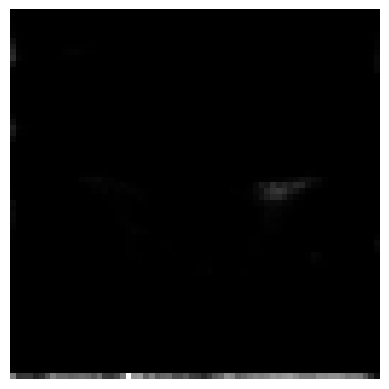

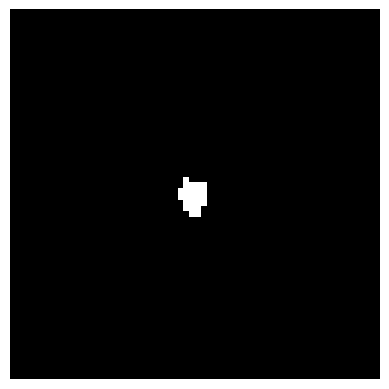

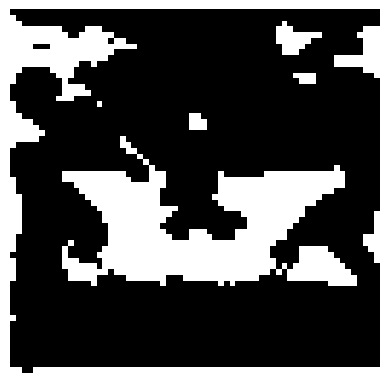

[[[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[1.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[1.]
   [1.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[1.]
   [1.]
   [0.]
   ...
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[1.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[1.]
   [1.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[1.]
   [1.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[1.]
   [1.]
   [1.]
   ...
   [1.]
   [1.]
   [1.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[1.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[1.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[1.

In [35]:
best_model = tuner.get_best_models(num_models=1)[0]

# Train the U-Net model
history = best_model.fit(x_train, y_train, batch_size=8, epochs=10, validation_split=0.1)

# Evaluate the best model
loss, accuracy = best_model.evaluate(x_val, y_val)  # Assuming you have a validation set
print(f"Best Model - Loss: {loss}, Accuracy: {accuracy}")

y_out = best_model.predict(x_val)
y_out = (y_out > 0.00001).astype(np.float32)
plt.imshow(y_out[0], cmap='gray')
plt.axis('off')  # To hide axis
plt.show()
# Optionally save the best model
best_model.save('best_unet_model.h5')


In [36]:
# Predict masks
predictions = best_model.predict(x_test)

# Post-process predictions
# Assuming masks are binary (0 or 1), threshold the predictions
predictions = (predictions > 0.00001).astype(np.uint8)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [37]:
import matplotlib.pyplot as plt

def save_predictions(predictions, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    for i, pred in enumerate(predictions):
        # Convert the prediction to an image
        pred_image = pred.squeeze()  # Remove single-dimensional entries
        pred_image = (pred_image * 255).astype(np.uint8)  # Scale to [0, 255] for saving as image
        output_path = os.path.join(output_folder, f'pred_{i}.png')
        plt.imsave(output_path, pred_image, cmap='gray')  # Save as grayscale image

# Define output folder for predictions
output_folder = '/content/drive/MyDrive/PROMISE12/output_data'  # Replace with your desired output folder path
save_predictions(predictions, output_folder)
